# Project 3: Reddit 

**Import libraries**

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#https://stackoverflow.com/questions/59799041/why-reddit-return-502-error-when-accessing-a-page-using-beautifulsoup4
# Set user agent to prevent status code issue
headers = {'user-agent':'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Mobile Safari/537.36'}
url = "https://api.pushshift.io/reddit/search/submission/" #Get the url
def read_data(params):
    response = requests.get(url, headers=headers,params=params)
    if response.status_code == 200: #Check status code for requests to ensure we are not getting a 400 or 500 code
        return response.json()['data'] 
    else:
        return []

In [3]:
def read_reddit_data(subreddit,num_records):
    before = None
    posts = []
    
    while(len(posts)<num_records):
        response = read_data({'subreddit': subreddit, 
                              'size':100, 
                              'sort':'desc',
                              'sort_type':'created_utc', 
                              'before':before, 
                              'fields':["id", "created_utc", "title", "selftext", "subreddit",
                                        "author_flair_text","link_flair_text"]})
        for post in response:
             if post.get('selftext', "").strip(" ") != "" :
                    posts.append(post)
        before = response[-1].get("created_utc")
 #https://stackoverflow.com/questions/20592808/add-all-elements-of-an-iterable-to-list
        time.sleep(1) # pauses for a second between each requests
    return posts

In [4]:
#get 'violinist' subreddit
violin_subreddit = read_reddit_data("violinist",1000)

In [5]:
#check length of subreddit
len(violin_subreddit)

1063

In [6]:
#get 'cello' subreddit
cello_subreddit = read_reddit_data("cello",1000)

In [7]:
#check length of subreddit
len(cello_subreddit)

1027

In [8]:
# Turn list of dictionaries to a data frame!
violinist_df = pd.DataFrame(violin_subreddit)
violinist_df.head(10)

,author_flair_text,created_utc,id,link_flair_text,selftext,subreddit,title
0,None,1623916196,o1rmpe,Technique,"When the score says Sul G, Sul D, IVeme chord,...",violinist,Question (as a beginner)
1,Expert,1623901354,o1nle1,NaN,"I mean anything ranging from posture, books, e...",violinist,If you could change one thing about how you le...
2,Beginner,1623897478,o1mcaq,NaN,"I got my current violin in December, and idk i...",violinist,Time for new strings?
3,None,1623896598,o1m1xq,NaN,[removed],violinist,Success story
4,None,1623884222,o1i0fi,Setup/Equipment,My daughter (12) and I went to a luthier yeste...,violinist,Trialing 1/2 size violins
5,None,1623878748,o1fz34,NaN,I have a late 19th century workshop violin out...,violinist,Violin out on trial: take to luthier?
6,None,1623866739,o1b7t4,Setup/Equipment,I just got my first violin last week and I am ...,violinist,Bridge Question
7,None,1623864467,o1aamm,NaN,"Hi, I'm sorry if I'm in the wrong subreddit! ...",violinist,Donating Violin?
8,None,1623854143,o16ckr,NaN,"Hi, I'm a beginner musician but I want to work...",violinist,How to become music tutor
9,Student,1623849616,o14pqh,Setup/Equipment,How do you practice when it is so hot inside?,violinist,Practice in heat


In [9]:
# Turn list of dictionaries to a data frame!
cello_df = pd.DataFrame(cello_subreddit)
cello_df.head(10)

,author_flair_text,created_utc,id,selftext,subreddit,title
0,None,1623898632,o1mpqb,Long story short my beloved Cello is now Firew...,Cello,"About to Purchase Hidersine Vivente, Need Pers..."
1,None,1623829311,o0zfou,"I played the cello for ~10 years, but haven’t ...",Cello,String Recommendations
2,None,1623812767,o0v9gr,How feasible would it be to self-teach myself ...,Cello,Self-teaching myself the cello
3,None,1623808690,o0u325,[deleted],Cello,"""Blackbird"" Cello Cover by Jacob Staron"
4,None,1623804745,o0sy1b,I'm looking to do some fun pedal stuff with my...,Cello,Best pick up for cello?
5,None,1623791621,o0or64,This is embarrassing to say but honestly my in...,Cello,Any tips on improving intonation?
6,None,1623772571,o0hn28,Hey there people from r/Cello!\n\nI'm looking ...,Cello,I'm looking for a cello player for a Zelda Arr...
7,None,1623770561,o0gvzw,[removed],Cello,I can't relax... help
8,None,1623763528,o0eawx,"Hi everyone,\n\nBeen playing cello off and on ...",Cello,How do you all practice?
9,None,1623681716,nzocca,I'm a good month into learning the cello and n...,Cello,Struggle with stretching my fingers


In [10]:
cello_df['author_flair_text'].value_counts()

Student                44
Bachelor of Music       3
Arrangements/Comp       1
cello prof.             1
Name of your group      1
High School Student     1
Name: author_flair_text, dtype: int64

In [11]:
violinist_df['author_flair_text'].value_counts()

Adult Beginner      64
Student             31
Intermediate        24
Teacher             17
Beginner            17
Amateur             16
Expert              13
Soloist              8
Music Major          7
Advanced             2
Viola                2
Gigging Musician     1
Name: author_flair_text, dtype: int64

In [12]:
violinist_df['link_flair_text'].value_counts()

Setup/Equipment               115
Technique                      76
Feedback                       53
Original                       24
Definitely Not About Cases     10
Violin Jam                      7
Share Your Playing              2
Composing                       1
Question                        1
**IMPORTANT**                   1
Help me Find Resources          1
Name: link_flair_text, dtype: int64

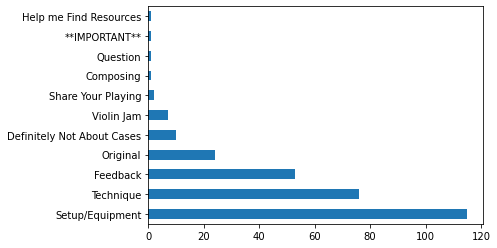

In [13]:
violinist_df['link_flair_text'].value_counts().plot(kind='barh');

<AxesSubplot:>

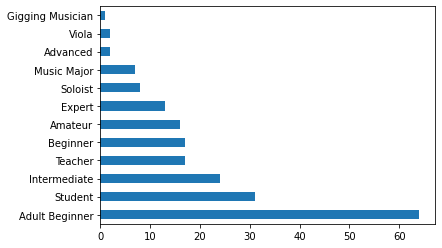

In [14]:
violinist_df['author_flair_text'].value_counts().plot(kind='barh')

<AxesSubplot:>

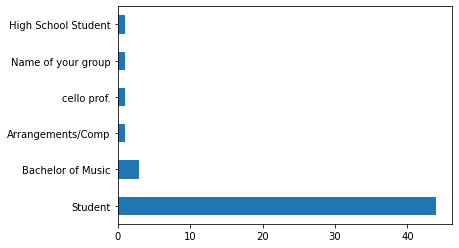

In [15]:
cello_df['author_flair_text'].value_counts().plot(kind='barh')

In [16]:
#instantiate counter vectorizer
cv = CountVectorizer(stop_words='english')

In [17]:
cv.fit(cello_df['title'])
cello_cv = cv.transform(cello_df['title'])
cello_cv_df = pd.DataFrame(cello_cv.todense(),columns=cv.get_feature_names())
cello_cv_df.head()

,02,10,100,1000,11,110,122,14,1400,170,...,zoom,аbоut,аnd,еxpеriеnсe,нis,оf,оnly,раssed,сallеd,тhеre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'key words')

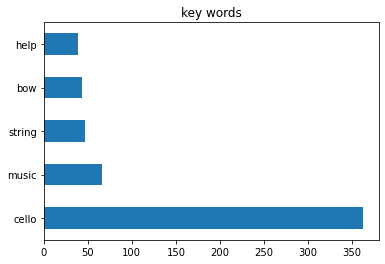

In [18]:
cello_cv_df.sum().sort_values(ascending=False).head(5).plot(kind='barh')
plt.title('key words')

In [19]:
cv.fit(violinist_df['title'])
violinist_cv = cv.transform(violinist_df['title'])
violinist_cv_df = pd.DataFrame(violinist_cv.todense(),columns=cv.get_feature_names())
violinist_cv_df.head()

,07,10,100,101,1099,11,13,15,1500,16ths,...,ysaye,ysaÿe,ysv104,zdzislaw,zigeunerweisen,zimmer,zoom,сriticism,バージョン,春のソナタ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
cello_cv_df.sum().sort_values(ascending=False).head(15)

cello       362
music        66
string       47
bow          43
help         39
question     37
looking      35
beginner     32
new          32
playing      31
zoom         31
play         29
does         28
advice       28
need         28
dtype: int64

In [21]:
violinist_cv_df.sum().sort_values(ascending=False).head(15)

violin       311
bow           64
help          54
question      47
music         44
beginner      44
play          44
playing       43
string        40
strings       37
new           37
violinist     36
practice      32
good          31
does          29
dtype: int64

Text(0.5, 1.0, 'key words')

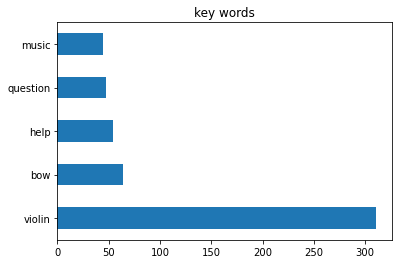

In [22]:
violinist_cv_df.sum().sort_values(ascending=False).head(5).plot(kind='barh')
plt.title('key words')

In [23]:
reddit_data = pd.concat([violinist_df,cello_df])

In [24]:
reddit_data.head(3)

,author_flair_text,created_utc,id,link_flair_text,selftext,subreddit,title
0,None,1623916196,o1rmpe,Technique,"When the score says Sul G, Sul D, IVeme chord,...",violinist,Question (as a beginner)
1,Expert,1623901354,o1nle1,NaN,"I mean anything ranging from posture, books, e...",violinist,If you could change one thing about how you le...
2,Beginner,1623897478,o1mcaq,NaN,"I got my current violin in December, and idk i...",violinist,Time for new strings?


In [25]:
reddit_data['author_flair_text'].value_counts()

Student                75
Adult Beginner         64
Intermediate           24
Beginner               17
Teacher                17
Amateur                16
Expert                 13
Soloist                 8
Music Major             7
Bachelor of Music       3
Viola                   2
Advanced                2
Arrangements/Comp       1
Name of your group      1
High School Student     1
cello prof.             1
Gigging Musician        1
Name: author_flair_text, dtype: int64

<AxesSubplot:>

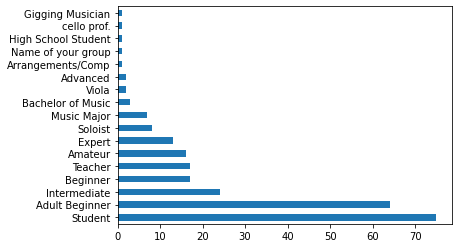

In [26]:
reddit_data['author_flair_text'].value_counts().plot(kind='barh')

In [27]:
cv.fit(reddit_data['title'])
reddit_data_cv = cv.transform(reddit_data['title'])
reddit_df = pd.DataFrame(reddit_data_cv.todense(),columns=cv.get_feature_names())
reddit_df.head()

,02,07,10,100,1000,101,1099,11,110,122,...,еxpеriеnсe,нis,оf,оnly,раssed,сallеd,сriticism,тhеre,バージョン,春のソナタ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

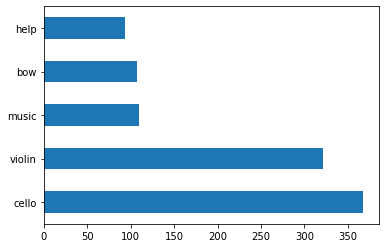

In [28]:
reddit_df.sum().sort_values(ascending=False).head(5).plot(kind='barh')

In [29]:
# Create Binary y column based on subreddit name
reddit_data['y'] = reddit_data['subreddit'].map(lambda x: 1 if x == 'violinist'else 0)

In [30]:
# Save data frame to csv
reddit_data.to_csv('../data/reddit_data.csv', index=False)

In [31]:
# read in collected subreddits
reddit_data = pd.read_csv('../data/reddit_data.csv')
reddit_data.head(3)

,author_flair_text,created_utc,id,link_flair_text,selftext,subreddit,title,y
0,NaN,1623916196,o1rmpe,Technique,"When the score says Sul G, Sul D, IVeme chord,...",violinist,Question (as a beginner),1
1,Expert,1623901354,o1nle1,NaN,"I mean anything ranging from posture, books, e...",violinist,If you could change one thing about how you le...,1
2,Beginner,1623897478,o1mcaq,NaN,"I got my current violin in December, and idk i...",violinist,Time for new strings?,1


In [32]:
# check random row 'title'
reddit_data['title'][4]

'Trialing 1/2 size violins'

In [33]:
#check shape of the data
reddit_data.shape

(2090, 8)

In [34]:
#check for missing values
reddit_data.isnull().sum()

author_flair_text    1837
created_utc             0
id                      0
link_flair_text      1799
selftext                0
subreddit               0
title                   0
y                       0
dtype: int64

In [35]:
reddit_data['y'].value_counts(normalize=True)

1    0.508612
0    0.491388
Name: y, dtype: float64

In [36]:
features='title'
X = reddit_data[features]
y = reddit_data['y']

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 random_state=42,
                                                 stratify=y) 

In [105]:
print(X_train.shape)
print(X_test.shape)

(1567,)
(523,)


In [106]:
#cv,rf
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9987236758136566, 0.7361376673040153)

In [107]:
#cv,lg
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('lg', LogisticRegressionCV(solver='liblinear'))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9157626037013401, 0.7151051625239006)

In [69]:
#cv,dt
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('dt', DecisionTreeClassifier())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9987236758136566, 0.7093690248565966)

In [70]:
#cv,mnb
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9151244416081685, 0.7495219885277247)

In [71]:
#tfidf,logreg
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegressionCV(solver='liblinear'))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8781110402042118, 0.7208413001912046)

In [72]:
#tfidf,mnb
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9215060625398851, 0.7284894837476099)

In [108]:
best_pipe = Pipeline([
    ('cv',CountVectorizer()),
    ('rfc',RandomForestClassifier())])

In [109]:
params_grid = {
    'rfc__n_estimators': [50, 100, 150, 200],
    'rfc__max_depth': [ 1, 2, 3, 4, 5]
}

In [113]:
gs = GridSearchCV(estimator = best_pipe, param_grid = params_grid, cv = 5)

In [114]:
gs.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cv', 'rfc', 'cv__analyzer', 'cv__binary', 'cv__decode_error', 'cv__dtype', 'cv__encoding', 'cv__input', 'cv__lowercase', 'cv__max_df', 'cv__max_features', 'cv__min_df', 'cv__ngram_range', 'cv__preprocessor', 'cv__stop_words', 'cv__strip_accents', 'cv__token_pattern', 'cv__tokenizer', 'cv__vocabulary', 'rfc__bootstrap', 'rfc__ccp_alpha', 'rfc__class_weight', 'rfc__criterion', 'rfc__max_depth', 'rfc__max_features', 'rfc__max_leaf_nodes', 'rfc__max_samples', 'rfc__min_impurity_decrease', 'rfc__min_impurity_split', 'rfc__min_samples_leaf', 'rfc__min_samples_split', 'rfc__min_weight_fraction_leaf', 'rfc__n_estimators', 'rfc__n_jobs', 'rfc__oob_score', 'rfc__random_state', 'rfc__verbose', 'rfc__warm_start'])

In [115]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [1, 2, 3, 4, 5],
                         'rfc__n_estimators': [50, 100, 150, 200]})

In [116]:
gs.best_score_

0.7274943529842697

In [117]:
# Evaluate model.
print(f'Score on training set: {gs.score(X_train, y_train)}')
print(f'Score on testing set: {gs.score(X_test, y_test)}')

Score on training set: 0.7638800255264837
Score on testing set: 0.7323135755258127


In [118]:
X_train

240                                              Bow hold
703                                  songs to collab with
945                                       Buying a violin
207                                 FIRST NOTE OF A PIECE
151     Online Middle School String Camps? (Perhaps in...
                              ...                        
485             Improving articulation with broken pinky?
751            Hi! Do you have some advice for busking? 👇
583     Can I make a right handed "electric" violin le...
1729    Do any of you here know where I can buy a bow ...
912     A list of concertos for anybody that doesn’t k...
Name: title, Length: 1567, dtype: object

In [93]:
pd.DataFrame({
    'features': X_train.tolist(),
    'feature importance': gs.best_estimator_.feature_importances_
}).sort_values(by='feature importance', ascending=False)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [119]:
# Use best scoring model to evaluate
predictions = gs.predict(X_test)
cm = confusion_matrix(y_test, predictions)

In [120]:
# Convert confusion matrix to dataframe
cm_df = pd.DataFrame(cm,
                    columns = ['predicted negative', 'predicted positive'],
                    index = ['actual negative', 'actual positive'])
cm_df

,predicted negative,predicted positive
actual negative,125,132
actual positive,8,258


In [125]:
# Calculate model accuracy
accuracy =(125+258)/(125+258+132+8)
accuracy*100

73.23135755258127

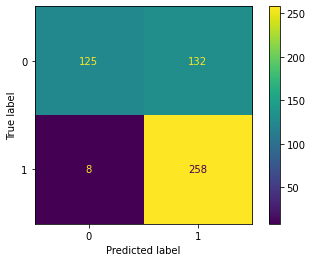

In [122]:
plot_confusion_matrix(gs, X_test, y_test)

In [123]:
# mash up X and y test vals into one df
test_df = pd.concat([X_test, y_test], axis=1)

# add preds to df
test_df['predictions'] = predictions

In [124]:
test_df[test_df['y'] != test_df['predictions']]

,title,y,predictions
1982,Dance of the Green Devil Story?,0,1
1148,"Тhеre is а Yоutuber сallеd ""Lеоn Fаrаdаy"" thаt...",0,1
1796,Is Vibrato Even Real?,0,1
1923,A dream I had last night,0,1
1572,Exercises to loosen the bow hand?,0,1
...,...,...,...
1296,The Legend of Afro Geisha,0,1
1788,Any tips for getting good time on sustained qu...,0,1
1339,"Hi, I'm a beginner and would love advice on so...",0,1
1670,Does anyone want to go on a journey creating t...,0,1
